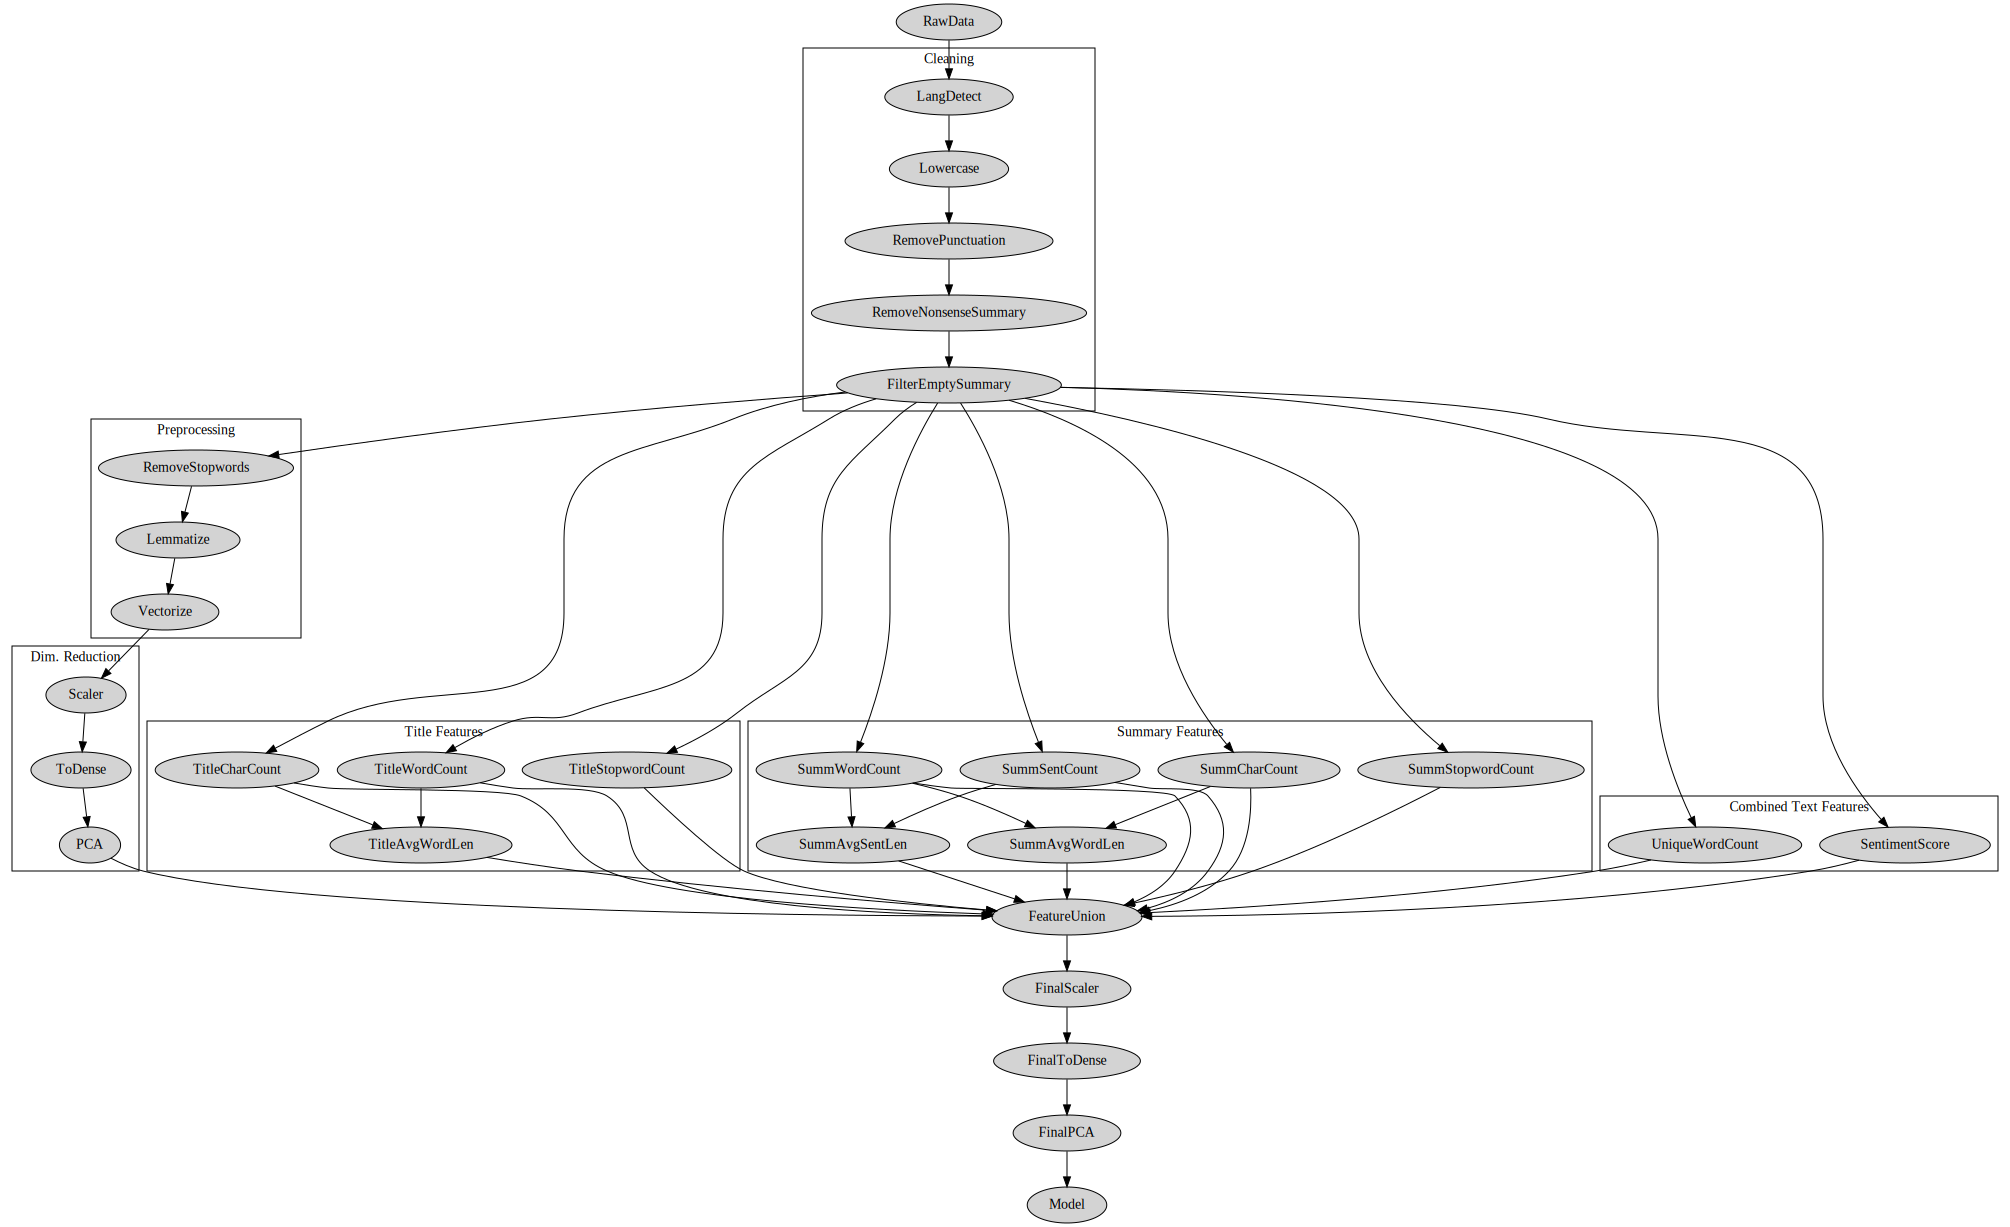

In [3]:
from graphviz import Digraph

g = Digraph('G', node_attr={'style': 'filled'})

with g.subgraph(name='cluster_cleaning') as c:
    c.attr(color='black', label='Cleaning')
    c.edges([
        ('LangDetect', 'Lowercase'),
        ('Lowercase', 'RemovePunctuation'),
        ('RemovePunctuation', 'RemoveNonsenseSummary'),
        ('RemoveNonsenseSummary', 'FilterEmptySummary')
    ])
    
with g.subgraph(name='cluster_preprocess') as c:
    c.attr(color='black', label='Preprocessing')
    c.edges([
        ('RemoveStopwords', 'Lemmatize'),
        ('Lemmatize', 'Vectorize')
    ])
    
with g.subgraph(name='cluster_dimred') as c:
    c.attr(color='black', label='Dim. Reduction')
    c.edges([
        ('Scaler', 'ToDense'),
        ('ToDense', 'PCA')
    ])
    
with g.subgraph(name='cluster_title') as c:
    c.attr(color='black', label='Title Features')
    c.edges([
        ('FilterEmptySummary', 'TitleCharCount'),
        ('FilterEmptySummary', 'TitleWordCount'),
        ('FilterEmptySummary', 'TitleStopwordCount'),
        ('TitleCharCount', 'TitleAvgWordLen'),
        ('TitleWordCount', 'TitleAvgWordLen')
    ])

with g.subgraph(name='cluster_summ') as c:
    c.attr(color='black', label='Summary Features')
    c.edges([
        ('FilterEmptySummary', 'SummCharCount'),
        ('FilterEmptySummary', 'SummWordCount'),
        ('FilterEmptySummary', 'SummSentCount'),
        ('FilterEmptySummary', 'SummStopwordCount'),
        ('SummCharCount', 'SummAvgWordLen'),
        ('SummWordCount', 'SummAvgWordLen'),
        ('SummWordCount', 'SummAvgSentLen'),
        ('SummSentCount', 'SummAvgSentLen'),
    ])
    
with g.subgraph(name='cluster_combined') as c:
    c.attr(color='black', label='Combined Text Features')
    c.edges([
        ('FilterEmptySummary', 'UniqueWordCount'),
        ('FilterEmptySummary', 'SentimentScore')
    ])

g.edge('RawData', 'LangDetect')
g.edge('FilterEmptySummary', 'RemoveStopwords')
g.edge('Vectorize', 'Scaler')

feature_list = [
    'PCA', 'TitleCharCount', 'TitleWordCount', 'TitleStopwordCount', 'TitleAvgWordLen',
    'SummCharCount', 'SummWordCount', 'SummSentCount', 'SummStopwordCount', 'SummAvgWordLen',
    'SummAvgSentLen', 'UniqueWordCount', 'SentimentScore'
]

for f in feature_list:
    g.edge(f, 'FeatureUnion')
    
with g.subgraph(name='clust_finaldimred') as c:
    c.attr(color='black', label='Final Dim. Reduction')
    c.edges([
        ('FinalScaler', 'FinalToDense'),
        ('FinalToDense', 'FinalPCA')
    ])

g.edge('FeatureUnion', 'FinalScaler')
g.edge('FinalPCA', 'Model')

u = g.unflatten(stagger=3)
u

In [57]:
import pandas as pd
import numpy as np

# Dataset URL:
# https://www.kaggle.com/datasets/athu1105/book-genre-prediction

# Read the data into dataframe
df = pd.read_csv('../data/book_genre_dataset.csv')

# Create a column with the combined title and summary
df['combined'] = df['title'] + '. ' + df['summary']

In [58]:
from sklearn.base import TransformerMixin, BaseEstimator

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.loc[:,self.variables]

In [59]:
import langdetect

class LangDetection(BaseEstimator, TransformerMixin):
    def __init__(self, lang='en'):
        self.lang = lang
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        X_['lang'] = X_.apply(lambda x: langdetect.detect(x))
        X_lang_only = X[X_['lang'] == self.lang]
        return X_lang_only

In [60]:
class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_lower = X.apply(lambda x: x.lower())
        return X_lower

In [61]:
import re

class RemovePunctuation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_no_punct = X.apply(lambda x: re.sub(r'[^\w\s]|_', '', x))
        return X_no_punct

In [62]:
class DropDataEntries(BaseEstimator, TransformerMixin):
    def __init__(self, ids):
        self.ids = ids
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        for i in self.ids:
            X_ = X_.drop(i)
        return X_     

In [63]:
from sklearn.pipeline import Pipeline

nonsense_summaries_idx = [338, 588, 834, 1574, 1772, 2410, 2485]

clean_text_pipeline = Pipeline([
    ('get_combined_text', FeatureSelector('combined')),
    ('detect_lang', LangDetection()),
    ('lowercase',    LowercaseTransformer()),
    ('remove_punctuation', RemovePunctuation()),
    ('drop_nonsense_summaries', DropDataEntries(nonsense_summaries_idx))
])

In [64]:
clean_text_pipeline

Pipeline(steps=[('get_combined_text', FeatureSelector(variables='combined')),
                ('detect_lang', LangDetection()),
                ('lowercase', LowercaseTransformer()),
                ('remove_punctuation', RemovePunctuation()),
                ('drop_nonsense_summaries',
                 DropDataEntries(ids=[338, 588, 834, 1574, 1772, 2410, 2485]))])

In [65]:
X_combined_clean = clean_text_pipeline.fit_transform(df)

#'338' in X_combined_clean
df.drop([i for i in range(len(df)) if i not in X_combined_clean])
X = df[['title','summary','combined']]
y = df['genre']
X.shape, y.shape

((4657, 3), (4657,))

In [66]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords):
        self.stopwords = stopwords
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_no_stopwords = X.apply(lambda x: ' '.join([w for w in x.split() if w not in self.stopwords]))
        return X_no_stopwords

[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
from nltk.stem import WordNetLemmatizer

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatizer):
        self.lemmatizer = lemmatizer
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        lemmatize_func = lambda x: ' '.join(
            [self.lemmatizer.lemmatize(w) for w in x.split()]
        )
        X_lemmatized = X.apply(lemmatize_func)
        return X_lemmatized

In [400]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import DenseTransformer

preprocess_text_pipeline = Pipeline([
    ('remove_stopwords', RemoveStopwords(stop_words)),
    ('lemmatize', Lemmatizer(WordNetLemmatizer())),
    ('tfidf', TfidfVectorizer()),
    ('select_k_best', SelectKBest(k=5000))
])

In [401]:
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import DenseTransformer
from sklearn.decomposition import PCA

dim_reduction_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('dense', DenseTransformer()),
    ('pca', PCA(n_components=5))
])

In [414]:
from sklearn.pipeline import FeatureUnion

text_pipeline = Pipeline([
    ('select_combined', FeatureSelector('combined')),
    ('preprocess', preprocess_text_pipeline),
    #('dense', DenseTransformer())
    #('dim_reduction', dim_reduction_pipeline),
])

In [415]:
def stopword_count(text):
    stopwords_in_text = [w for w in text.split() if w in stop_words]
    return len(stopwords_in_text)

In [416]:
class TitleSummaryFE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        feats = pd.DataFrame()
        feats['char_count'] = X_.apply(lambda x: len(x))
        feats['word_count'] = X_.apply(lambda x: len(x.split()))
        feats['avg_word_len'] = feats['char_count'] / feats['word_count']
        feats['stopword_count'] = X_.apply(stopword_count)
        return feats

In [417]:
from sklearn.preprocessing import FunctionTransformer

title_features = Pipeline([
    ('select_title', FeatureSelector('title')),
    ('title_features', TitleSummaryFE()),
])

In [418]:
summary_features = Pipeline([
    ('select_summary', FeatureSelector('summary')),
    ('summary_features', TitleSummaryFE()),
])

In [419]:
from nltk.sentiment import SentimentIntensityAnalyzer

class CombinedFE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        feats = pd.DataFrame()
        sia = SentimentIntensityAnalyzer()
        X_ = X.copy()
        feats['unique_word_count'] = X_.apply(lambda x: len(set(x.split())))
        feats['unique_word_ratio'] = feats['unique_word_count'] / X_.apply(lambda x: len(x.split()))
        feats['sentiment_score'] = X_.apply(lambda x: sia.polarity_scores(x)['compound'])
        return feats

In [420]:
combined_features = Pipeline([
    ('select_combined', FeatureSelector('combined')),
    ('combined_features', CombinedFE()),
])

In [421]:
features = FeatureUnion([
    ('text', text_pipeline),
    ('title', title_features),
    ('summary', summary_features),
    ('combined', combined_features)
])

In [437]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('features', features),
    #('dim_reduction', dim_reduction_pipeline),
    ('svc', LinearSVC(dual=False))
    #('knn', KNeighborsClassifier())
])

In [438]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def run_experiment(X, y, pipeline, num_expts=100):
    scores = list()
    for i in range(num_expts):
        X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2)
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_true, y_pred)
        scores.append(score)
    
    print(f"Average accuracy over {num_expts} experiments: {sum(scores) / num_expts} \n")
    print("Classification report for the last experiment:\n")
    print(classification_report(y_true, y_pred))

In [440]:
run_experiment(X, y, pipeline)
#X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2)
#model = pipeline.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#score = accuracy_score(y_true, y_pred)
#print(score)

Average accuracy over 100 experiments: 0.672607296137339 

Classification report for the last experiment:

              precision    recall  f1-score   support

       crime       0.75      0.70      0.72       115
     fantasy       0.63      0.71      0.67       175
     history       0.58      0.78      0.67       106
      horror       0.74      0.43      0.54       136
  psychology       0.94      0.67      0.78        24
     romance       0.25      0.19      0.21        16
     science       0.74      0.72      0.73       120
      sports       0.94      0.73      0.82        22
    thriller       0.61      0.70      0.65       200
      travel       0.83      0.56      0.67        18

    accuracy                           0.66       932
   macro avg       0.70      0.62      0.65       932
weighted avg       0.68      0.66      0.66       932



In [433]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('select_combined',
                                                                  FeatureSelector(variables='combined')),
                                                                 ('preprocess',
                                                                  Pipeline(steps=[('remove_stopwords',
                                                                                   RemoveStopwords(stopwords={'a',
                                                                                                              'about',
                                                                                                              'above',
                                                                                                              'after',
                                                                                                              'again',
                                                                                                              'against',
                                                                                                              'ain',
                                                                                                              'all',
                                                                                                              'am',
                                                                                                              'an',
                                                                                                              'and',
                                                                                                              'any',
                                                                                                              'are',
                                                                                                              'aren',
                                                                                                              "aren't",
                                                                                                              'as',
                                                                                                              'at',
                                                                                                              'be',
                                                                                                              'because',
                                                                                                              'been...
                                                                  FeatureSelector(variables='title')),
                                                                 ('title_features',
                                                                  TitleSummaryFE())])),
                                                ('summary',
                                                 Pipeline(steps=[('select_summary',
                                                                  FeatureSelector(variables='summary')),
                                                                 ('summary_features',
                                                                  TitleSummaryFE())])),
                                                ('combined',
                                                 Pipeline(steps=[('select_combined',
                                                                  FeatureSelector(variables='combined')),
                                                                 ('combined_features',
                                                                  CombinedFE())]))])),
                ('svc', LinearSVC(dual=False))])

In [279]:
class Apply(BaseEstimator, TransformerMixin):
    def __init__(self, fn):
        self.fn = fn
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_transformed = X.apply(self.fn)
        return X_transformed

In [276]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(type(X))
        if isinstance(X, np.ndarray):
            print(f"{np.sum(np.isnan(X))} NaN values found\n")
        if isinstance(X, pd.core.frame.DataFrame):
            print(f"{X.isnull().sum()} null values found\n")
        print(X.shape)
        return X
    
    def fit(self, X, y=None, **fit_params):
        print("Running fit() now!\n")
        return self